<a href="https://colab.research.google.com/github/porekhov/drug_design_2024/blob/main/MD_water_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install -q openmm mdanalysis mdtraj nglview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 55.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-kernel-gateway 2.5.2 requires notebook<7.0,>=5.7.6, but you have notebook 7.5.0 which 

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import openmm as mm
from openmm import app, unit, Platform

#===========================================================
# 1. Load your GROMACS .gro file (water box)
#===========================================================
gro_filename = "box.gro"  # make sure box.gro is in the working directory

gro = app.GromacsGroFile(gro_filename)
positions = gro.getPositions(asNumpy=True)  # Quantity in nm
box_vectors = gro.getPeriodicBoxVectors()   # periodic box

n_atoms = positions.shape[0]
if n_atoms % 3 != 0:
    raise ValueError(f"Number of atoms ({n_atoms}) is not a multiple of 3. "
                     "This script assumes pure 3-site water (3 atoms per molecule).")
n_waters = n_atoms // 3
print("Loaded", gro_filename)
print("Number of atoms:", n_atoms)
print("Number of water molecules:", n_waters)

Loaded box.gro
Number of atoms: 1530
Number of water molecules: 510


In [37]:
import nglview as nv
from google.colab import output
output.enable_custom_widget_manager()

# Load your GROMACS structure file
view = nv.show_file("box.gro")

# Optional: adjust the widget size
view.layout.width = "500px"
view.layout.height = "500px"

# Set background color
view.background = "white"

# Clear default representations and add your own
view.clear_representations()
view.add_representation("ball+stick")  # good for water

# Center/zoom on the system
view.center()

view

NGLWidget(layout=Layout(height='500px', width='500px'))

In [11]:
#===========================================================
# 2. Build a pure water topology compatible with TIP3P
#    (residue name HOH, atoms O/H1/H2 with bonds)
#===========================================================
top = app.Topology()
chain = top.addChain()

O_el = app.element.oxygen
H_el = app.element.hydrogen

atoms = []
for i in range(n_waters):
    res = top.addResidue("HOH", chain)
    aO  = top.addAtom("O",  O_el, res)
    aH1 = top.addAtom("H1", H_el, res)
    aH2 = top.addAtom("H2", H_el, res)
    top.addBond(aO, aH1)
    top.addBond(aO, aH2)
    atoms.extend([aO, aH1, aH2])

# Set periodic box
top.setPeriodicBoxVectors(box_vectors)

# Wrap in a Modeller
modeller = app.Modeller(top, positions)

In [12]:
#===========================================================
# 3. Create system, integrator, simulation
#===========================================================
forcefield = app.ForceField("tip3p.xml")   # pure TIP3P water

system = forcefield.createSystem(
    modeller.topology,
    nonbondedMethod=app.PME,
    nonbondedCutoff=1.0*unit.nanometer,
    constraints=app.HBonds
)

temperature = 300 * unit.kelvin
friction = 1.0 / unit.picosecond
dt = 0.002 * unit.picoseconds  # 2 fs

integrator = mm.LangevinIntegrator(temperature, friction, dt)

# Platform
platform = Platform.getPlatformByName("OpenCL")

simulation = app.Simulation(modeller.topology, system, integrator, platform)
simulation.context.setPositions(modeller.positions)

# Make sure the context box matches the gro box
simulation.context.setPeriodicBoxVectors(*box_vectors)

simulation.context.setVelocitiesToTemperature(temperature)

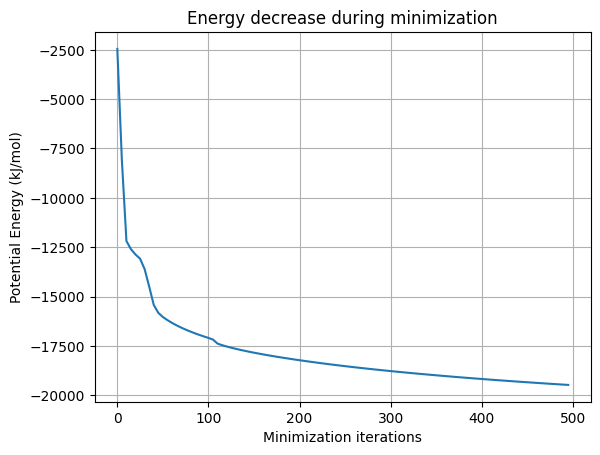

In [14]:
#===========================================================
# 4. Minimization
#===========================================================

energies = []
steps = []

for i in range(100):
    simulation.minimizeEnergy(maxIterations=5)   # small minimization steps
    state = simulation.context.getState(getEnergy=True)
    E = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)

    energies.append(E)
    steps.append(i*5)

plt.plot(steps, energies)
plt.xlabel("Minimization iterations")
plt.ylabel("Potential Energy (kJ/mol)")
plt.title("Energy decrease during minimization")
plt.grid()
plt.show()

In [15]:
#===========================================================
# 5. Production run: 100 ps, record positions
#===========================================================
prod_time_ps = 100.0
dt_ps = dt.value_in_unit(unit.picoseconds)
n_steps = int(prod_time_ps / dt_ps)
report_interval = 10  # save every 10 steps

print(f"Running production: {prod_time_ps} ps ({n_steps} steps)")

pos_list = []
times_ps = []

# initial frame (t = 0)
state = simulation.context.getState(getPositions=True, enforcePeriodicBox=False)
pos_nm = state.getPositions(asNumpy=True).value_in_unit(unit.nanometer)
pos_list.append(pos_nm)
times_ps.append(0.0)

for step in range(1, n_steps + 1):
    simulation.step(1)
    if step % report_interval == 0:
        state = simulation.context.getState(getPositions=True, enforcePeriodicBox=False)
        pos_nm = state.getPositions(asNumpy=True).value_in_unit(unit.nanometer)
        pos_list.append(pos_nm)
        times_ps.append(step * dt_ps)

pos_array = np.array(pos_list)  # (n_frames, n_atoms, 3)
times_ps = np.array(times_ps)

n_frames = pos_array.shape[0]
print("Recorded frames:", n_frames)

Running production: 100.0 ps (50000 steps)
Recorded frames: 5001


In [16]:
#===========================================================
# 6. Select water oxygen atoms (one point per molecule)
#===========================================================
# We constructed the topology as [O, H1, H2] repeating, so oxygens are 0,3,6,...
oxygen_indices = np.arange(0, n_atoms, 3, dtype=int)
n_oxygens = len(oxygen_indices)
print("Number of O atoms:", n_oxygens)

pos_O = pos_array[:, oxygen_indices, :]  # (n_frames, n_oxygens, 3)

#===========================================================
# 7. MSD and RMS displacement (Einstein relation)
#   MSD(t) = < |r_i(t) - r_i(0)|^2 >_i
#   In 3D: MSD ≈ 6 D t
#===========================================================
disp = pos_O - pos_O[0]       # displacements from t=0
sq_disp = np.sum(disp**2, axis=2)  # (n_frames, n_oxygens)
msd = np.mean(sq_disp, axis=1)     # average over molecules
rms_disp = np.sqrt(msd)

# Fit MSD(t) in the last 80% of points
fit_start_idx = int(0.2 * n_frames)
t_fit = times_ps[fit_start_idx:]
msd_fit = msd[fit_start_idx:]

coeffs = np.polyfit(t_fit, msd_fit, 1)
slope = coeffs[0]     # nm^2 / ps
intercept = coeffs[1]

D_nm2_ps = slope / 6.0
D_m2_s = D_nm2_ps * 1e-6  # 1 nm^2/ps = 1e-6 m^2/s

print(f"Slope of MSD(t): {slope:.4f} nm^2/ps")
print(f"Diffusion coefficient D ≈ {D_nm2_ps:.4f} nm^2/ps")
print(f"Diffusion coefficient D ≈ {D_m2_s:.4e} m^2/s")

Number of O atoms: 510
Slope of MSD(t): 0.0278 nm^2/ps
Diffusion coefficient D ≈ 0.0046 nm^2/ps
Diffusion coefficient D ≈ 4.6282e-09 m^2/s


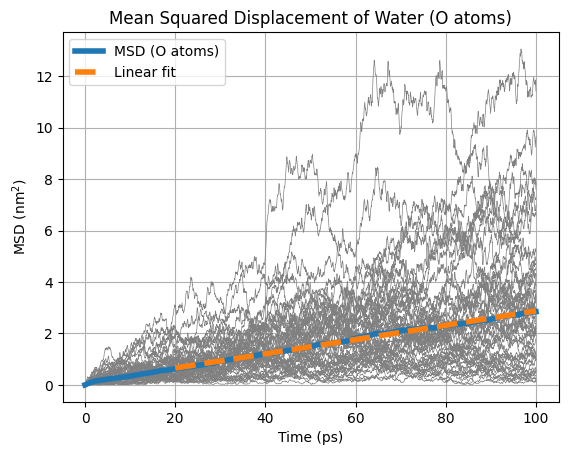

In [36]:
#===========================================================
# 8. Plot MSD
#===========================================================
plt.figure()

for i in range(0, sq_disp.shape[1], 10):
    plt.plot(times_ps, sq_disp[:, i], lw = 0.5, color = 'grey')

plt.plot(times_ps, msd, label="MSD (O atoms)", lw = 4)
plt.plot(t_fit, slope*t_fit + intercept, "--", label="Linear fit", lw = 4)
plt.xlabel("Time (ps)")
plt.ylabel("MSD (nm$^2$)")
plt.title("Mean Squared Displacement of Water (O atoms)")
plt.grid(True)
plt.legend()
plt.show()